In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import preprocessed data file
stroke = pd.read_csv('../Dataset/healthcare-dataset-stroke-data-cleaned.csv')
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.2+ KB


### Prepare train and test datasets

In [3]:
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import RobustScaler

In [4]:
# Prepare the train and test datasets
X = stroke.drop('stroke', axis='columns')
y = stroke['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Create categorical encoder for the categorial variables
cat_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
encoder = ce.OneHotEncoder(cols=cat_cols, handle_unknown='return_nan', return_df=True, use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)

# Create scaler for the numerical variables
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[['age', 'avg_glucose_level', 'bmi']]))
X_train_scaled.columns = ['age', 'avg_glucose_level', 'bmi']

# Combine the encoded and scaled variables
X_train_processed = pd.concat([X_train_encoded.drop(['age', 'avg_glucose_level', 'bmi'], axis=1).reset_index(drop=True), X_train_scaled], axis=1)

# Encode the categorical variables and scale the numerical variables of the test dataset
X_test_encoded = encoder.transform(X_test)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[['age', 'avg_glucose_level', 'bmi']]))
X_test_processed = pd.concat([X_test_encoded.drop(['age', 'avg_glucose_level', 'bmi'], axis=1).reset_index(drop=True), X_test_scaled], axis=1)

C:\Users\c_lin\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### Building predictive models

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import loguniform
from sklearn.inspection import plot_partial_dependence

#### First model: Logistic Regression

In [6]:
model_LR = LogisticRegression()
model_LR.fit(X_train_processed, y_train)
predict_LR = model_LR.predict(X_test_processed)

In [7]:
# Let's take a look at the model's accuracy
train_accuracy = accuracy_score(y_train, model_LR.predict(X_train_processed))
test_accuracy = accuracy_score(y_test, predict_LR)
print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

Train accuracy: 0.9515537068754588
Test accuracy: 0.9510763209393346


In [8]:
print("Confusion matrix:\n", confusion_matrix(y_test, predict_LR))
print("\nClassification report:\n", classification_report(y_test, predict_LR))

Confusion matrix:
 [[972   0]
 [ 50   0]]

Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



C:\Users\c_lin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Our first model yields pretty high train set and test set accuracies (~95%).  However, in the medical setting, it is common to look at specificity and sensitivity to evaluate medical test.  Specificity is the proportion of correct negative results which is also known as the True Negative Rate.  Sensitivity is the proportion of correct positive results which is known as the True Positive Rate and is also called Recall. 

$$
Specificity = \frac{True Negative (TN)}{True Negative (TN) + False Positive (FP)}
$$

$$
Sensitivity = \frac{True Positive (TP)}{True Positive (TP) + False Negative (FN)}
$$

From our model prediction, we see that even though the train and test sets accuracies are very high, the sensitivity or recall rate on the minority class (class 1) is 0% because none of the positive case was being captured. That means none of the patient who has stroke was labeled correctly.

Many machine learning algorithms have the default threshold set at 0.5 for interpreting probabilities to class labels. All values equal or greater than the threshold are mapped to one class and all other values are mapped to another class. We can plot the distribution of the predicted probabilities for class 1.

<AxesSubplot:>

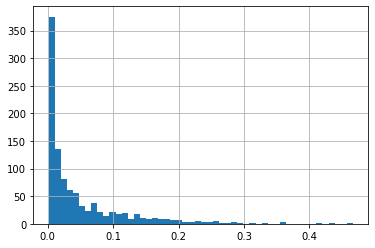

In [9]:
# The predict probability of the positive outcome only
prob_1 = model_LR.predict_proba(X_test_processed)[:, 1]
pd.Series(prob_1).hist(bins=50)

The plot shows all of the class 1 predicted probabilities is less than 0.5. This is why all the positive class samples were mislabeled.  This proves that the imbalanced dataset leads to learning bias on the majority class (class 0). 

Let's plot the ROC Curve which focuses on the performance on the minority class only.

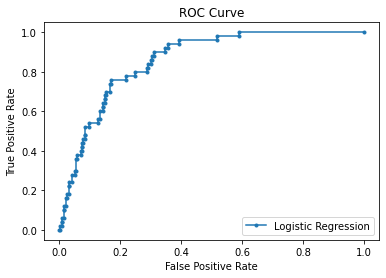

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, prob_1)
plt.plot(fpr, tpr, marker='.', label='Logistic Regression')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

The area under the ROC Curve is commonly used for comparing classification models for imbalanced dataset.

In [11]:
auc = roc_auc_score(y_test, prob_1)
print("Model AUC score is", auc)

Model AUC score is 0.8593415637860082


In order to improve the recall rate, we will use a method called Threshold-moving to tune the threshold which used to map the probabilities to class labels to improve the performance of our classifier.  In order to find the optimal threshold that results in the best balance of true positive rate and false positive rate, we will use the Youden's J statistic to help finding the optimal threshold.

In [12]:
# A function to find the optimal threshold having the best Youden's J-score
def best_threshold(fpr, tpr, thresh):
    # define a range of thresholds
    J = tpr - fpr
    idx = np.argmax(J)
    best_thresh = thresh[idx]
    return best_thresh

In [13]:
best_thresh = best_threshold(fpr, tpr, thresholds)
print("Best threshold is {}".format(best_thresh))

Best threshold is 0.08224323381322148


In [14]:
# Performance of the classifier with the best threshold
predict_LR_opt_thresh = np.where(prob_1 > best_thresh, 1, 0)
cm = confusion_matrix(y_test, predict_LR_opt_thresh)
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_test, predict_LR_opt_thresh))
test_accuracy = accuracy_score(y_test, predict_LR_opt_thresh)
print("Test accuracy:", test_accuracy)

Confusion matrix:
 [[808 164]
 [ 13  37]]

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90       972
           1       0.18      0.74      0.29        50

    accuracy                           0.83      1022
   macro avg       0.58      0.79      0.60      1022
weighted avg       0.95      0.83      0.87      1022

Test accuracy: 0.8268101761252447


We see that the recall rate increases from 0% to 88%!

From the above equations calculating the specificity and sensitivity, the True Positive, False Positive, and False Negative rates are used.  However, the True Negative rate is not taken into account.  The True Negative rate is very important in the medical setting.  You do not want to tell a 'false alarm' result to a patient who does not have a stroke which will cause a lot of emotional stress to the patient. 

In order to take into account all four positive and negative rates, a combined single indicator, the Diagnostic Odds ratio (DOR), is used in the medical world.  DOR is a measurement of the diagnostic accuracy of a test.  It is the ratio of the Positive Likelihood Ratio LR+ (the probability of detection) to the Negative Likelihood Ratio LR- (the probabiliy of false alarm).  

$$
DOR = \frac{LR+}{LR-} = \frac{\frac{TP}{Fp}}{\frac{FN}{FN}}
$$

Calculate the Diagnostic Odds ratio (DOR) of our model.

In [15]:
def DOR(cm):
    TN = cm[0][0] # True negative
    FP = cm[0][1] # False positive
    FN = cm[1][0] # False negative
    TP = cm[1][1] # True positive

    dor = (TP / FP) / (FN / TN)
    return dor

In [16]:
dor = DOR(cm)
print("Model DOR score is", dor)

Model DOR score is 14.022514071294559


In [17]:
# store model performance

performance = {'Model': [],
               'Train accuracy': [],
               'Test accuracy': [],
               'ROC AUC score': [],
               'DOR score': [],
               'Best threshold': []}

def performance_report(performance, model_name, train_accuracy, test_accuracy, auc, dor, best_thresh):
    performance['Model'].append(model_name)
    performance['Train accuracy'].append(train_accuracy)
    performance['Test accuracy'].append(test_accuracy)
    performance['ROC AUC score'].append(auc)
    performance['DOR score'].append(dor)
    performance['Best threshold'].append(best_thresh)
    
performance_report(performance, 'Logistic Regression', train_accuracy, test_accuracy, auc, dor, best_thresh)

In [18]:
per = pd.DataFrame(performance)
print(per)

                 Model  Train accuracy  Test accuracy  ROC AUC score  \
0  Logistic Regression        0.951554        0.82681       0.859342   

   DOR score  Best threshold  
0  14.022514        0.082243  


#### Build baseline KNN, Decision Tree, Random Forest and Gradient Boost baseline models

In [19]:
# Build baseline models
model_KNN = KNeighborsClassifier()
model_DT = DecisionTreeClassifier()
model_RF = RandomForestClassifier()
model_GB = GradientBoostingClassifier()

models = [['K-Neighbors', model_KNN],
          ['Decision Tree',  model_DT],
          ['Random Forest', model_RF],
          ['Gradient Boosting', model_GB]]

for model_name, model in models:
    model.fit(X_train_encoded, y_train)
    prob_1 = model.predict_proba(X_test_encoded)[:, 1]
    
    auc = roc_auc_score(y_test, prob_1)
    
    fpr, tpr, thresholds = roc_curve(y_test, prob_1)
    best_thresh = best_threshold(fpr, tpr, thresholds)
    
    predict_opt_thresh = np.where(prob_1 > best_thresh, 1, 0)
    cm = confusion_matrix(y_test, predict_opt_thresh)
    
    dor = DOR(cm)
    
    print("----------" + model_name + "----------\n")
    print("Confusion matrix:\n", cm)
    print("\nClassification report:\n", classification_report(y_test, predict_opt_thresh))

    train_accuracy = accuracy_score(y_train, model.predict(X_train_encoded))
    test_accuracy = accuracy_score(y_test, predict_opt_thresh)
    
    performance_report(performance, model_name, train_accuracy, test_accuracy, auc, dor, best_thresh)

----------K-Neighbors----------

Confusion matrix:
 [[937  35]
 [ 43   7]]

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       972
           1       0.17      0.14      0.15        50

    accuracy                           0.92      1022
   macro avg       0.56      0.55      0.56      1022
weighted avg       0.92      0.92      0.92      1022

----------Decision Tree----------

Confusion matrix:
 [[972   0]
 [ 50   0]]

Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



<ipython-input-15-ec72ec02660f>:7: RuntimeWarning: invalid value encountered in longlong_scalars
  dor = (TP / FP) / (FN / TN)
C:\Users\c_lin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------Random Forest----------

Confusion matrix:
 [[753 219]
 [ 15  35]]

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.77      0.87       972
           1       0.14      0.70      0.23        50

    accuracy                           0.77      1022
   macro avg       0.56      0.74      0.55      1022
weighted avg       0.94      0.77      0.83      1022

----------Gradient Boosting----------

Confusion matrix:
 [[721 251]
 [  8  42]]

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.74      0.85       972
           1       0.14      0.84      0.24        50

    accuracy                           0.75      1022
   macro avg       0.57      0.79      0.55      1022
weighted avg       0.95      0.75      0.82      1022



In [20]:
print(pd.DataFrame(performance).sort_values(by = ['DOR score', 'ROC AUC score'], ascending=False))

                 Model  Train accuracy  Test accuracy  ROC AUC score  \
4    Gradient Boosting        0.959139       0.746575       0.861780   
0  Logistic Regression        0.951554       0.826810       0.859342   
3        Random Forest        0.999755       0.771037       0.789712   
1          K-Neighbors        0.951798       0.923679       0.709198   
2        Decision Tree        1.000000       0.951076       0.567593   

   DOR score  Best threshold  
4  15.080677        0.048700  
0  14.022514        0.082243  
3   8.022831        0.070000  
1   4.358140        0.200000  
2        NaN        1.000000  


#### Build XGBoost model

According to the results of the baseline models, Gradient Boosting model has the highest ROC AUC score.  We will use XGBoost to build an ensemble model to see if we can get a better result.

In [21]:
# Build baseline XGBoost model
model_XGB = XGBClassifier(objective='binary:logistic', use_label_encoder=False, 
                          eval_metric='auc', seed=7)
model_XGB.fit(X_train_encoded, y_train)
predict_XGB = model_XGB.predict(X_test_encoded)
print("Confusion matrix:\n", confusion_matrix(y_test, predict_XGB))
print("\nClassification report:\n", classification_report(y_test, predict_XGB))

Confusion matrix:
 [[960  12]
 [ 46   4]]

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.25      0.08      0.12        50

    accuracy                           0.94      1022
   macro avg       0.60      0.53      0.55      1022
weighted avg       0.92      0.94      0.93      1022



C:\Users\c_lin\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


We will also need to move the threshold in order to get a better recall rate.  The *scale_pos_weight* parameter in XGBoost is for tuning the threshold.  A typical value for the weight is the ratio of the negative class to positive class.

In [22]:
class_count = y_train.value_counts()
weight = class_count[0] / class_count[1]
weight

19.537688442211056

In [23]:
model_XGB = XGBClassifier(objective='binary:logistic', use_label_encoder=False, 
                          scale_pos_weight=weight, eval_metric='auc', seed=123)
model_XGB.fit(X_train_encoded, y_train)
predict_XGB = model_XGB.predict(X_test_encoded)
print("---------- Positive weight = 20 ----------\n")
cm = confusion_matrix(y_test, predict_XGB)
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_test, predict_XGB))

train_accuracy = accuracy_score(y_train, model_XGB.predict(X_train_encoded))
test_accuracy = accuracy_score(y_test, predict_XGB)
auc = roc_auc_score(y_test, model_XGB.predict_proba(X_test_encoded)[:, 1])
dor = DOR(cm)

---------- Positive weight = 20 ----------

Confusion matrix:
 [[931  41]
 [ 41   9]]

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       972
           1       0.18      0.18      0.18        50

    accuracy                           0.92      1022
   macro avg       0.57      0.57      0.57      1022
weighted avg       0.92      0.92      0.92      1022



In [24]:
performance_report(performance, 'XGBoost', train_accuracy, test_accuracy, auc, dor, (1/weight))

In [25]:
print(pd.DataFrame(performance).sort_values(by = ['DOR score', 'ROC AUC score'], ascending=False))

                 Model  Train accuracy  Test accuracy  ROC AUC score  \
4    Gradient Boosting        0.959139       0.746575       0.861780   
0  Logistic Regression        0.951554       0.826810       0.859342   
3        Random Forest        0.999755       0.771037       0.789712   
5              XGBoost        0.994372       0.919765       0.809465   
1          K-Neighbors        0.951798       0.923679       0.709198   
2        Decision Tree        1.000000       0.951076       0.567593   

   DOR score  Best threshold  
4  15.080677        0.048700  
0  14.022514        0.082243  
3   8.022831        0.070000  
5   4.984533        0.051183  
1   4.358140        0.200000  
2        NaN        1.000000  


### Hyperparameters Tuning

#### Logistic Regression model tuning

In [26]:
# Tuning hyperparameters
param_grid_lr = {'C': loguniform(1e-5, 100), 'penalty': ['l2']}

model_LR_cv = RandomizedSearchCV(model_LR, param_grid_lr, scoring='roc_auc', cv=5)
model_LR_cv.fit(X_train_processed, y_train)

best_model = model_LR_cv.best_estimator_
print("Tuned Logistic Regression Parameters: {}".format(model_LR_cv.best_params_))
predict_LR_tuned = best_model.predict(X_test_processed)

prob_1 = best_model.predict_proba(X_test_processed)[:, 1]

auc = roc_auc_score(y_test, prob_1)
    
fpr, tpr, thresholds = roc_curve(y_test, prob_1)
best_thresh = best_threshold(fpr, tpr, thresholds)
    
predict_opt_thresh = np.where(prob_1 > best_thresh, 1, 0)
cm = confusion_matrix(y_test, predict_opt_thresh)
dor = DOR(cm)

train_accuracy = accuracy_score(y_train, best_model.predict(X_train_processed))
test_accuracy = accuracy_score(y_test, predict_opt_thresh)

performance_report(performance, 'Tuned Logistic Regression', train_accuracy, test_accuracy, auc, dor, best_thresh)

Tuned Logistic Regression Parameters: {'C': 1.4196401564925063, 'penalty': 'l2'}


In [27]:
print(pd.DataFrame(performance).sort_values(by = ['DOR score', 'ROC AUC score'], ascending=False))

                       Model  Train accuracy  Test accuracy  ROC AUC score  \
6  Tuned Logistic Regression        0.951554       0.701566       0.859115   
4          Gradient Boosting        0.959139       0.746575       0.861780   
0        Logistic Regression        0.951554       0.826810       0.859342   
3              Random Forest        0.999755       0.771037       0.789712   
5                    XGBoost        0.994372       0.919765       0.809465   
1                K-Neighbors        0.951798       0.923679       0.709198   
2              Decision Tree        1.000000       0.951076       0.567593   

   DOR score  Best threshold  
6  16.506132        0.042314  
4  15.080677        0.048700  
0  14.022514        0.082243  
3   8.022831        0.070000  
5   4.984533        0.051183  
1   4.358140        0.200000  
2        NaN        1.000000  


#### Random Forest model tuning

In [28]:
# Tuning hyperparameters
param_grid_rf = {'n_estimators': [x for x in range(50,500,50)],
                 'min_samples_split': [x for x in range(10,100)],
                 'min_samples_leaf': [x for x in range(10,100)],
                 'max_depth': [x for x in range(1,11)]
}

model_RF_cv = RandomizedSearchCV(model_RF, param_grid_rf, scoring='roc_auc', cv=5)
model_RF_cv.fit(X_train_encoded, y_train)
best_model = model_RF_cv.best_estimator_
print("Tuned Random Forest Parameter: {}".format(model_RF_cv.best_params_))

Tuned Random Forest Parameter: {'n_estimators': 350, 'min_samples_split': 37, 'min_samples_leaf': 67, 'max_depth': 5}


In [29]:
predict_RF_tuned = best_model.predict(X_test_encoded)
prob_1 = best_model.predict_proba(X_test_encoded)[:, 1]

auc = roc_auc_score(y_test, prob_1)
    
fpr, tpr, thresholds = roc_curve(y_test, prob_1)
best_thresh = best_threshold(fpr, tpr, thresholds)
    
predict_opt_thresh = np.where(prob_1 > best_thresh, 1, 0)
cm = confusion_matrix(y_test, predict_opt_thresh)
dor = DOR(cm)

train_accuracy = accuracy_score(y_train, best_model.predict(X_train_encoded))
test_accuracy = accuracy_score(y_test, predict_opt_thresh)
    
performance_report(performance, 'Tuned Random Forest', train_accuracy, test_accuracy, auc, dor, best_thresh)

#### Gradient Boosting model tuning

In [30]:
# Tuning hyperparameters
param_grid_gb = {'n_estimators': [2, 4, 6, 8, 10, 20, 40, 60, 80, 100], # try between 100 to 500
                 'min_samples_split': [x for x in range(10,100)],
                 'min_samples_leaf': [x for x in range(10,100)],
                 'max_depth': [x for x in range(1,11)]
}

model_GB_cv = RandomizedSearchCV(model_GB, param_grid_gb, scoring='roc_auc', cv=5)
model_GB_cv.fit(X_train_encoded, y_train)
best_model = model_GB_cv.best_estimator_
print("Tuned Random Forest Parameter: {}".format(model_GB_cv.best_params_))

Tuned Random Forest Parameter: {'n_estimators': 60, 'min_samples_split': 75, 'min_samples_leaf': 34, 'max_depth': 2}


In [31]:
predict_GB_tuned = best_model.predict(X_test_encoded)
prob_1 = best_model.predict_proba(X_test_encoded)[:, 1]

auc = roc_auc_score(y_test, prob_1)
    
fpr, tpr, thresholds = roc_curve(y_test, prob_1)
best_thresh = best_threshold(fpr, tpr, thresholds)
    
predict_opt_thresh = np.where(prob_1 > best_thresh, 1, 0)
cm = confusion_matrix(y_test, predict_opt_thresh)
dor = DOR(cm)

train_accuracy = accuracy_score(y_train, best_model.predict(X_train_encoded))
test_accuracy = accuracy_score(y_test, predict_opt_thresh)
    
performance_report(performance, 'Tuned Gradient Boosting', train_accuracy, test_accuracy, auc, dor, best_thresh)

In [32]:
per = pd.DataFrame(performance)
print(per.sort_values(by = ['DOR score', 'ROC AUC score'], ascending=False))

                       Model  Train accuracy  Test accuracy  ROC AUC score  \
8    Tuned Gradient Boosting        0.951554       0.765166       0.875761   
6  Tuned Logistic Regression        0.951554       0.701566       0.859115   
7        Tuned Random Forest        0.951309       0.829746       0.858477   
4          Gradient Boosting        0.959139       0.746575       0.861780   
0        Logistic Regression        0.951554       0.826810       0.859342   
3              Random Forest        0.999755       0.771037       0.789712   
5                    XGBoost        0.994372       0.919765       0.809465   
1                K-Neighbors        0.951798       0.923679       0.709198   
2              Decision Tree        1.000000       0.951076       0.567593   

   DOR score  Best threshold  
8  19.483139        0.055254  
6  16.506132        0.042314  
7  15.833333        0.088429  
4  15.080677        0.048700  
0  14.022514        0.082243  
3   8.022831        0.070000  
5 

<AxesSubplot:xlabel='ROC AUC score', ylabel='Model'>

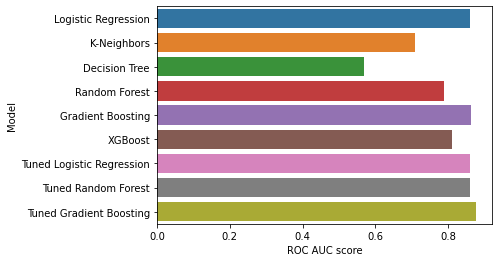

In [33]:
sns.barplot(data=per, x='ROC AUC score', y='Model')

<AxesSubplot:xlabel='DOR score', ylabel='Model'>

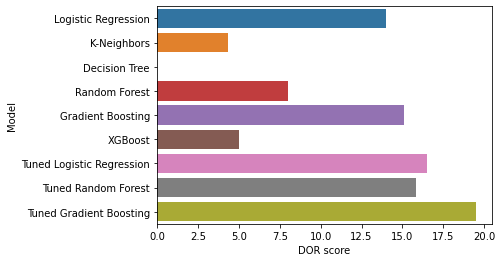

In [34]:
sns.barplot(data=per, x='DOR score', y='Model')

From the above performance report, the Tuned Gradient Boosting model has both the highest ROC AUC score and highest DOR score.  

### Feature Importance

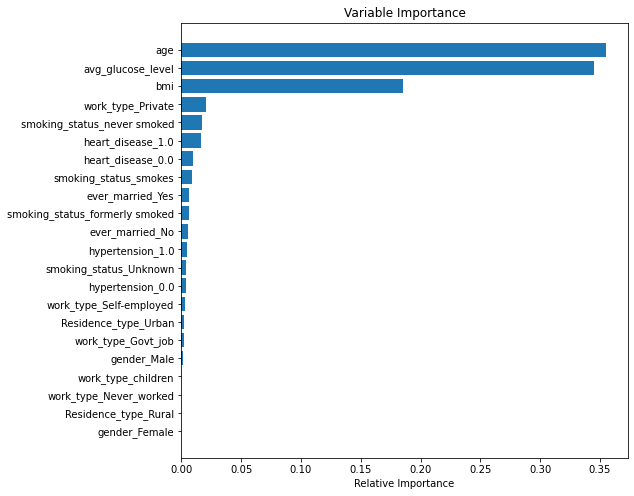

In [35]:
feature_importance = model_GB.feature_importances_

# make importances relative to max importance
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_encoded.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

From the above plot, we see that *age* and *avg_glucose_level* are the two most important features.  They contribute close to 70% of the importance.

### Partial Dependence Plot of the 3 most important features

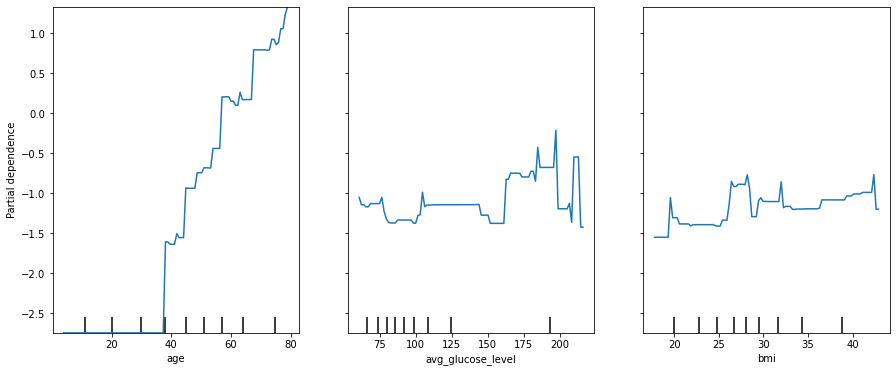

In [36]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_partial_dependence(model_GB, X_train_encoded, ["age", "avg_glucose_level", "bmi"], ax=ax)

The age and the average glucose level contribute the most to the risk of having stroke.  After the age of 40, the risk increases every year.  If a person has prediabetes or diabetes (average glucocse level above 150 mg/dL), the risk will also increase.  